# 基于K近邻的啤酒瓶数量检测

##  预处理

---

### 二值化 vs 边缘检测

- 二值化优点:

    计算连通域，简单
    
- 二值化缺点：

    暗色的瓶盖无法检测，由于框的边缘过亮，无法做到两全其美(Bad/9)


- 边缘检测优点：

    边缘，与亮度关系较小，暗色瓶盖依然能检测

- 边缘检测缺点：

    框被边缘也会被检测，噪声大(Good/29)
    
    K近邻：抗噪声vs噪声容忍

## 图像特点

- 啤酒瓶装在框中
- 啤酒瓶之间距离大致固定
- 框大多是正的，有斜着放的但是倾斜角度不大


## 运行

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# 图片缩小
def Shrink_img(img, step):
    m,n = img.shape
    small_img = np.zeros((int(m / step), int(n / step)), np.uint8)
    for i in range(int(m / step)):
        for j in range(int(n / step)):
                small_img[i, j] = img[i * step, j * step]
    return small_img

开始预处理

我认为难处理的图：
Good/1
Good/29
Bad/3
Bad/9
Bad/15
Bad/19
Bad/21

最难处理的：Bad/9.tif Good/29.tif

(300, 409)

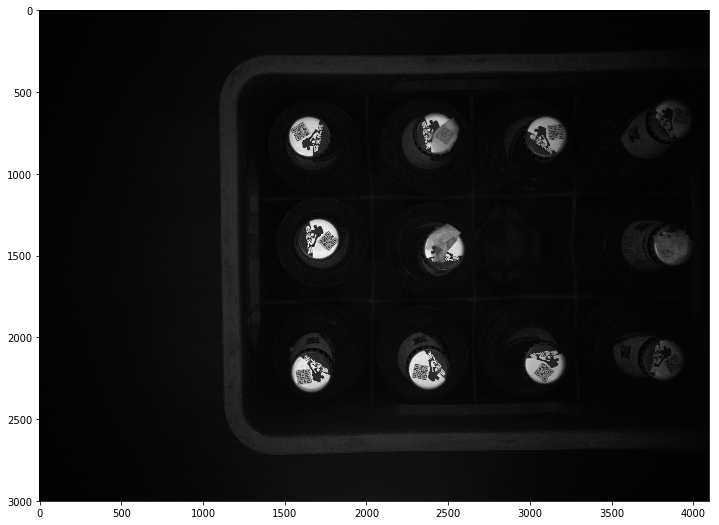

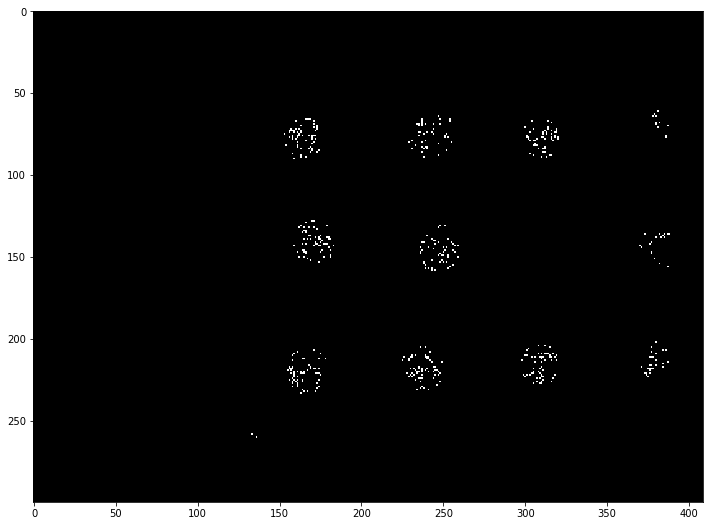

In [18]:
img = cv2.imread("Beer/Bad/1.tif")#读入图像
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#将图像转化为灰度图像
# image = Shrink_img(image, 20)
plt.figure(figsize=(12, 16))
plt.imshow(image, cmap='gray')
canny = cv2.Canny(image, 20, 100)
# canny = canny[2: m - 2, 2: n - 2]
canny = Shrink_img(canny, 10)
m, n = canny.shape
box = (m * 3) / 16
cv2.imwrite("canny.jpeg", canny)
plt.figure(figsize=(12, 16))
plt.imshow(canny, cmap='gray')
canny.shape

寻找框中心（不理想情况Good/29, Bad/1）

156

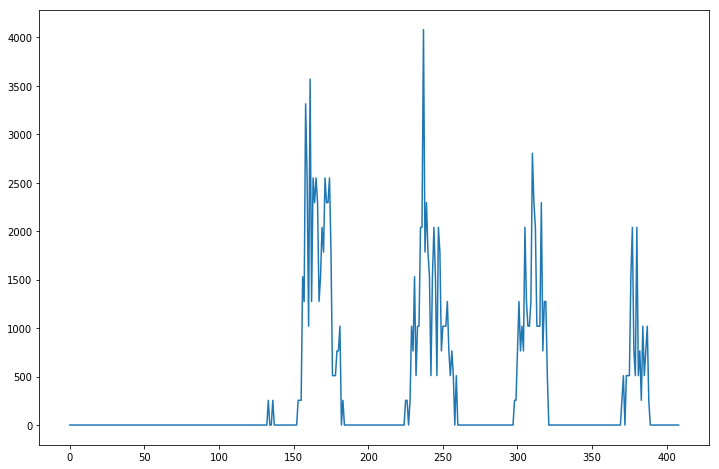

In [19]:
img_x, img_y = canny.shape
a, b = np.where(canny==255)
edge_T = np.vstack((a, b))
edge = edge_T.T
canny.sum(axis=0)
plt.figure(figsize = (12, 8))
plt.plot(canny.sum(axis=0))
temp = np.where((canny.sum(axis=0) > 1200))
k = temp[0].shape[0]
k
for i in range(k):
    first_left = temp[0][i]
#     if(canny[first_left])
    # 周围都很高才算是圆
    if(canny.sum(axis=0)[first_left - 10: first_left + 10].sum() / 20 > 500):
        break
first_left

66

229

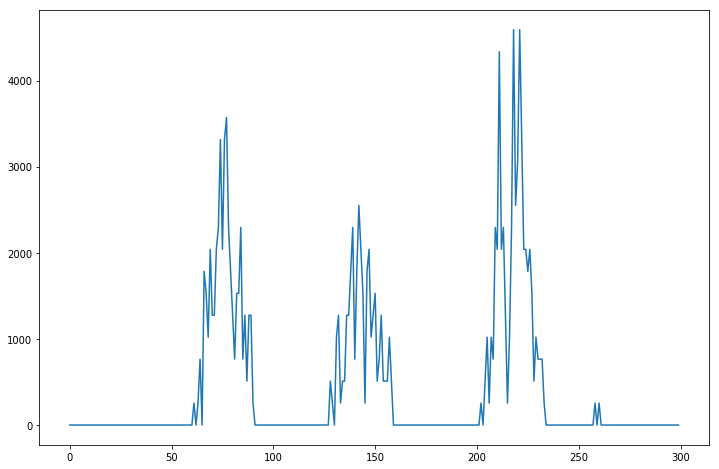

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(canny.sum(axis=1))
temp = np.where((canny.sum(axis=1) > 1000))
k = temp[0].shape[0]
first_top = temp[0][0]
first_bot = temp[0][k - 1]
# for i in range(k):
#     first_left = temp[0][i]
# #     if(canny[first_left])
#     # 周围都很高才算是圆
#     if(canny.sum(axis=0)[first_left - 10: first_left + 10].sum() / 20 > 500):
#         break
display(first_top, first_bot)

和图片看起来位置对应的图

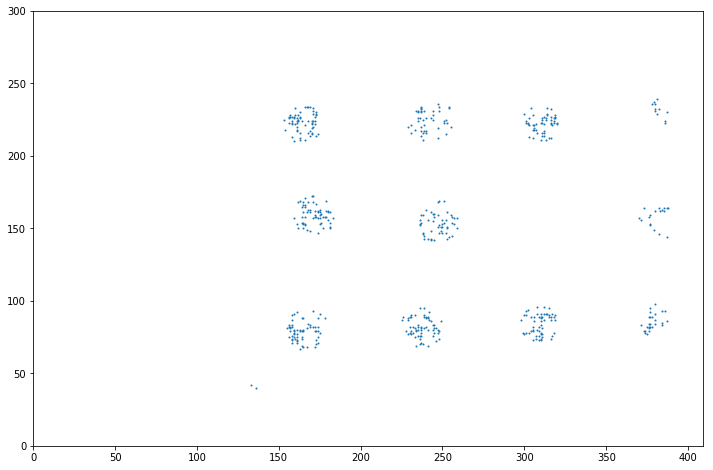

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xlim(0, img_y)
plt.ylim(0, img_x)
ax.scatter(edge[:, 1], img_x-edge[:, 0], s = 1)

根据数字坐标画出来的图

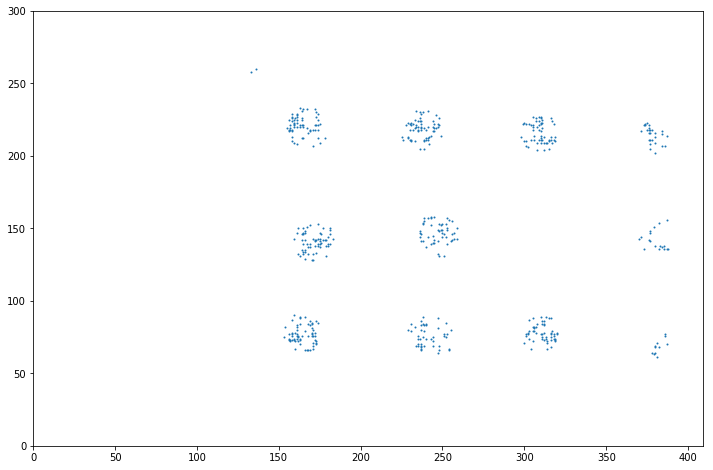

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xlim(0, img_y)
plt.ylim(0, img_x)
ax.scatter(edge[:, 1], edge[:, 0], s = 1)

In [23]:
x_center, y_center = edge[:, 0].mean(), edge[:, 1].mean()
x_center,y_center
y_center = first_left + 2.1 * box
if((first_top < 200) and (first_bot > 100)):
    pass
elif(first_top > 200):
    x_center = first_top + 2.1 * box
elif(first_bot < 100):
    x_center = first_top - 2.1 * box

In [24]:
initial_centroids = np.array([[x_center - 1.3 * box, y_center - 1.8 * box], [x_center - 1.3 * box, y_center - 0.5 * box], [x_center - 1.3 * box, y_center + 0.5 * box], [x_center - 1.3 * box, y_center + 1.8 * box], [x_center, y_center - 1.8 * box], [x_center, y_center - 0.5 * box],[x_center, y_center + 0.5 * box], [x_center, y_center + 1.8 * box], [x_center + 1.3 * box, y_center - 1.8 * box], [x_center + 1.3 * box, y_center - 0.5 * box],[x_center + 1.3 * box, y_center + 0.5 * box], [x_center + 1.3 * box, y_center + 1.8 * box]])

大致预判的啤酒瓶位置

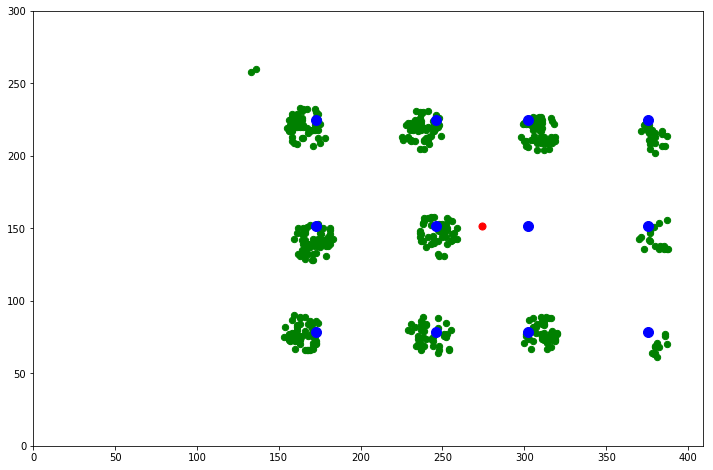

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xlim(0, img_y)
plt.ylim(0, img_x)
ax.scatter(edge[:, 1], edge[:, 0], s = 40, c='g')
ax.scatter(initial_centroids[:, 1], initial_centroids[:, 0], s = 100, c = 'b')
ax.scatter(y_center,x_center, s = 50, c = 'r')

In [26]:
# 给每个点分配最近的聚类中心
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 10000000000000000000000000000000000000000000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

In [12]:
# 计算新的聚类中心
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [13]:
# K近邻的整体代码
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [27]:
idx, centroids = run_k_means(edge, initial_centroids, 4)

/home/luyuxuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [15]:
def show_result(edge, idx, centroids, k):
    cluster1 = edge[np.where(idx == 0)[0],:]
    cluster2 = edge[np.where(idx == 1)[0],:]
    cluster3 = edge[np.where(idx == 2)[0],:]
    cluster4 = edge[np.where(idx == 3)[0],:]
    cluster5 = edge[np.where(idx == 4)[0],:]
    cluster6 = edge[np.where(idx == 5)[0],:]
    cluster7 = edge[np.where(idx == 6)[0],:]
    cluster8 = edge[np.where(idx == 7)[0],:]
    cluster9 = edge[np.where(idx == 8)[0],:]
    cluster10 = edge[np.where(idx == 9)[0],:]
    cluster11 = edge[np.where(idx == 10)[0],:]
    cluster12 = edge[np.where(idx == 11)[0],:]

    fig, ax = plt.subplots(figsize=(12,8))
    plt.xlim(0, img_y)
    plt.ylim(0, img_x)
    
    ax.scatter(cluster1[:,1], cluster1[:,0], s=40, color='#FF7F50', label='Cluster 1')
    ax.scatter(cluster2[:,1], cluster2[:,0], s=40, color='#DC143C', label='Cluster 2')
    ax.scatter(cluster3[:,1], cluster3[:,0], s=40, color='#00FFFF', label='Cluster 3')
    ax.scatter(cluster4[:,1], cluster4[:,0], s=40, color='#00008B', label='Cluster 4')
    ax.scatter(cluster5[:,1], cluster5[:,0], s=40, color='#B22222', label='Cluster 5')
    ax.scatter(cluster6[:,1], cluster6[:,0], s=40, color='#FF00FF', label='Cluster 6')
    ax.scatter(cluster7[:,1], cluster7[:,0], s=40, color='#808080', label='Cluster 7')
    ax.scatter(cluster8[:,1], cluster8[:,0], s=40, color='#ADFF2F', label='Cluster 8')
    ax.scatter(cluster9[:,1], cluster9[:,0], s=40, color='#FF69B4', label='Cluster 9')
    ax.scatter(cluster10[:,1], cluster10[:,0], s=40, color='#4B0082', label='Cluster 10')
    ax.scatter(cluster11[:,1], cluster11[:,0], s=40, color='#7CFC00', label='Cluster 11')
    ax.scatter(cluster12[:,1], cluster12[:,0], s=40, color='#BA55D3', label='Cluster 12')
    ax.scatter(centroids[:,1], centroids[:,0], s = 100)
    ax.legend()
    plt.show()

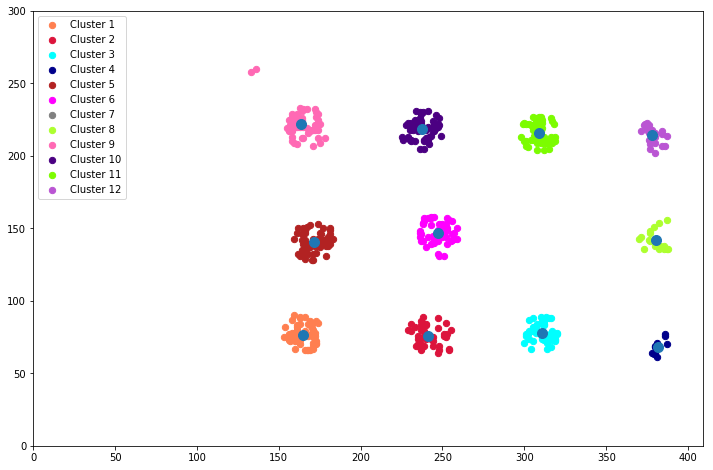

array([[ 76.76190476, 164.49206349],
       [ 75.61363636, 241.25      ],
       [ 78.        , 310.83018868],
       [ 68.27272727, 381.81818182],
       [140.68852459, 171.24590164],
       [146.96078431, 247.07843137],
       [         nan,          nan],
       [142.05555556, 380.16666667],
       [222.234375  , 163.3125    ],
       [218.49206349, 237.36507937],
       [215.96491228, 309.22807018],
       [214.59259259, 378.07407407]])

In [16]:
show_result(edge, idx, centroids, 12)
centroids

In [17]:
np.isnan(centroids)[:, 0][0]
counter = 0
for i in range(12):
    if(np.isnan(centroids)[:, 0][i] == False):
        counter += 1
print('图片中啤酒瓶的数量为', counter, '瓶')

图片中啤酒瓶的数量为 11 瓶
